

## W281 Data Preprocessing
### Upload the dataset

In [1]:
import pandas as pd

# Load dataset
prefix_label = "Military_and_Civilian_Vehicles_Classification/Labels/CSV_Format/"
df = pd.read_csv(prefix_label+"train_labels.csv")

# Display multi-label dataset
df

filename  width  height  \
0                  000_14M0LD-e1525732547750-400x250.jpg    400     250   
1                  000_14M0LD-e1525732547750-400x250.jpg    400     250   
2                               000_1H95VB.width-800.jpg    800     532   
3                 000_1LC27X-e1570900274807-1024x640.jpg   1024     640   
4                 000_1LC27X-e1570900274807-1024x640.jpg   1024     640   
...                                                  ...    ...     ...   
10713              _110072566_gettyimages-1134568783.jpg    410     230   
10714                                _57608873_drone.jpg   1024     576   
10715  _83539969_b47a9225-6db2-4f83-975d-576edf0279e6...    660     371   
10716  _90482169_a1648047-7a18-441a-923c-c44260e5b19e...    410     230   
10717                    _98332434_mediaitem98332433.jpg    660     371   

                     class  xmin  ymin  xmax  ymax  
0            military tank   121    60   220   144  
1            military tank   198   108   371   197  
2        military aircraft    30   168   622   505  
3            military tank    78    92   858   563  
4           military truck   816   288  1012   554  
...                    ...   ...   ...   ...   ...  
10713    military aircraft    29     5   368   151  
10714  military helicopter   182   119   855   403  
10715    military aircraft    39    41   589   302  
10716    military aircraft    83    36   326   149  
10717  military helicopter   175     9   442   115  

[10718 rows x 8 columns]

## Remove Multi-label

In [2]:
# Calculate bounding box area
df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

# Keep only the row with the largest bounding box for each image
df_cleaned = df.loc[df.groupby("filename")["area"].idxmax()].drop(columns=["area"])

# Save cleaned dataset
df_cleaned.to_csv("train_labels_cleaned.csv", index=False)

# Display single-label dataset
df_cleaned


filename  width  height  \
1                  000_14M0LD-e1525732547750-400x250.jpg    400     250   
2                               000_1H95VB.width-800.jpg    800     532   
3                 000_1LC27X-e1570900274807-1024x640.jpg   1024     640   
5                             0023ae82ca0f1487c33a46.jpg    900     618   
6      01-BOAC-Comet-1-G-BOAC-AI-PM-1953-0603-Marvin-...   1626    1038   
...                                                  ...    ...     ...   
10678                 yemen-krQF--621x414LiveMintJPG.jpg    621     414   
10680                           yfpj25etn5clno4v0euw.jpg    795     498   
10695                           z1-tank-firing-600-2.jpg    600     410   
10696                 zimbabwe-story-xl_111517074456.jpg    647     404   
10701                              zunum_aero_za10_1.jpg    800     600   

                   class  xmin  ymin  xmax  ymax  
1          military tank   198   108   371   197  
2      military aircraft    30   168   622   505  
3          military tank    78    92   858   563  
5      civilian aircraft     5    62   857   590  
6      civilian aircraft   115   375  1593   784  
...                  ...   ...   ...   ...   ...  
10678     military truck    16   261   564   404  
10680      military tank     6   178   414   461  
10695      military tank    48   151   444   353  
10696      military tank   137   137   541   352  
10701  civilian aircraft   156   239   624   437  

[6705 rows x 8 columns]

In [3]:
# Get class distribution
class_counts = df_cleaned["class"].value_counts()

# Get width and height range
width_range = (df_cleaned["width"].min(), df_cleaned["width"].max())
height_range = (df_cleaned["height"].min(), df_cleaned["height"].max())

# Display results
print("Class Distribution:\n", class_counts)
print("\nWidth Range:", width_range)
print("Height Range:", height_range)

Class Distribution:
 class
military tank          1615
military helicopter    1172
civilian car           1024
military aircraft       970
military truck          963
civilian aircraft       961
Name: count, dtype: int64

Width Range: (84, 7800)
Height Range: (100, 7472)


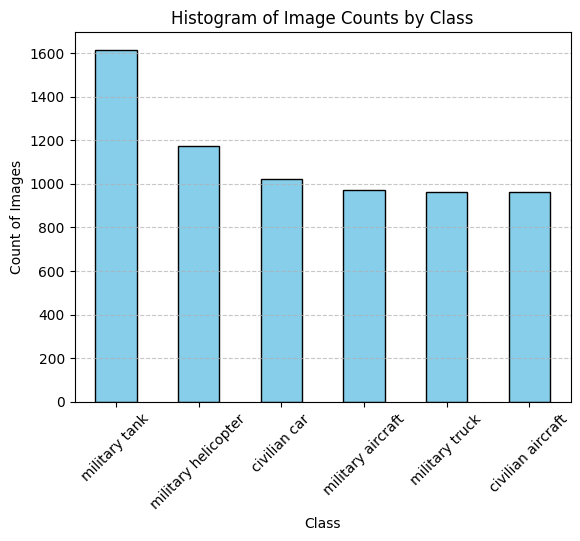

In [4]:
# histogram of image count by class

import pandas as pd
import matplotlib.pyplot as plt

# Plot histogram
class_counts = df_cleaned['class'].value_counts()
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('Class')
plt.ylabel('Count of Images')
plt.title('Histogram of Image Counts by Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

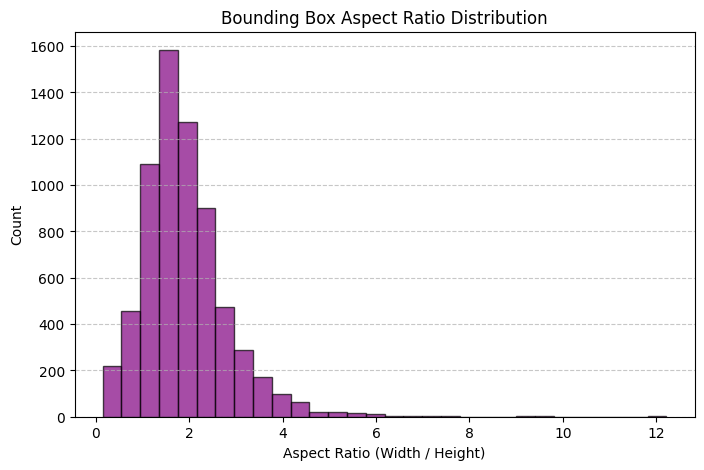

In [5]:
# Bounding Box Aspect Ration Distribution:
# Understand how objects' shapes vary

# Compute aspect ratio
df_cleaned["aspect_ratio"] = (df_cleaned["xmax"] - df_cleaned["xmin"]) / (df_cleaned["ymax"] - df_cleaned["ymin"])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df_cleaned["aspect_ratio"], bins=30, color='purple', alpha=0.7, edgecolor='black')

plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Count')
plt.title('Bounding Box Aspect Ratio Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

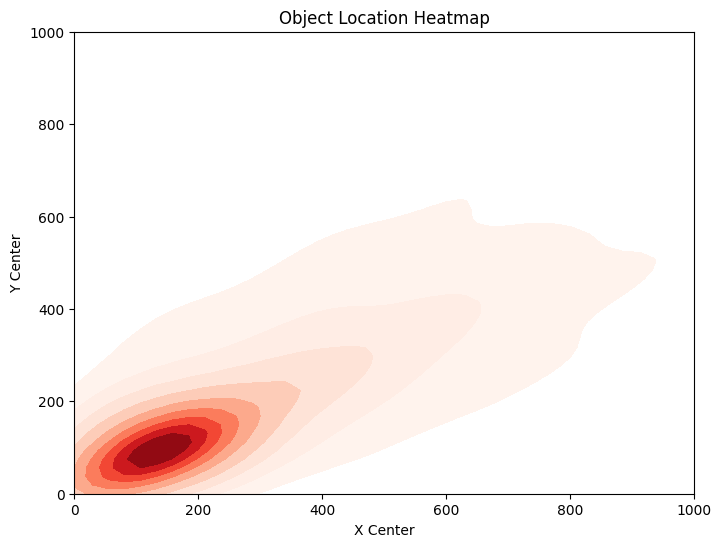

In [6]:
# Object Size Heatmap (where objects most commonly appear in images)
import seaborn as sns
import matplotlib.pyplot as plt

# Compute bounding box centers
df["x_center"] = (df["xmin"] + df["xmax"]) / 2
df["y_center"] = (df["ymin"] + df["ymax"]) / 2

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["x_center"], y=df["y_center"], cmap="Reds", fill=True, thresh=0.1)

# Limit the axes range
plt.xlim(0, 1000)  # Set x-axis range
plt.ylim(0, 1000)  # Set y-axis range

plt.xlabel('X Center')
plt.ylabel('Y Center')
plt.title('Object Location Heatmap')

plt.show()

## Weekly Update: Features Selection
### Step 1: Load Dataset and Select Sample Images
* This code randomly selects one military and one civilian vehicle image from `df_cleaned`.

In [7]:
import random

# Select one military and one civilian image
military_sample = df_cleaned[df_cleaned["class"].str.contains("military aircraft")].sample(1)
civilian_sample = df_cleaned[df_cleaned["class"].str.contains("civilian aircraft")].sample(1)

# Get file paths and labels
prefix_image = "Military_and_Civilian_Vehicles_Classification/Images/"
military_image = prefix_image+military_sample["filename"].values[0]
civilian_image = prefix_image+civilian_sample["filename"].values[0]

military_image = "Military_and_Civilian_Vehicles_Classification/Images/images215(5).jpg"
civilian_image = "Military_and_Civilian_Vehicles_Classification/Images/Most-common-commercial-airplane-Boeing-767.jpg"

print(f"Military Image: {military_image}, Class: {military_sample['class'].values[0]}")
print(f"Civilian Image: {civilian_image}, Class: {civilian_sample['class'].values[0]}")

"""
Military Image: Military_and_Civilian_Vehicles_Classification/Images/images305(5).jpg, Class: military aircraft
Civilian Image: Military_and_Civilian_Vehicles_Classification/Images/images265(10).jpg, Class: civilian aircraft
"""

Military Image: Military_and_Civilian_Vehicles_Classification/Images/images215(5).jpg, Class: military aircraft
Civilian Image: Military_and_Civilian_Vehicles_Classification/Images/Most-common-commercial-airplane-Boeing-767.jpg, Class: civilian aircraft


'\nMilitary Image: Military_and_Civilian_Vehicles_Classification/Images/images305(5).jpg, Class: military aircraft\nCivilian Image: Military_and_Civilian_Vehicles_Classification/Images/images265(10).jpg, Class: civilian aircraft\n'

### Step 2: Apply Edge Detection (Canny)
* This applies edge detection to both military and civilian vehicle images.

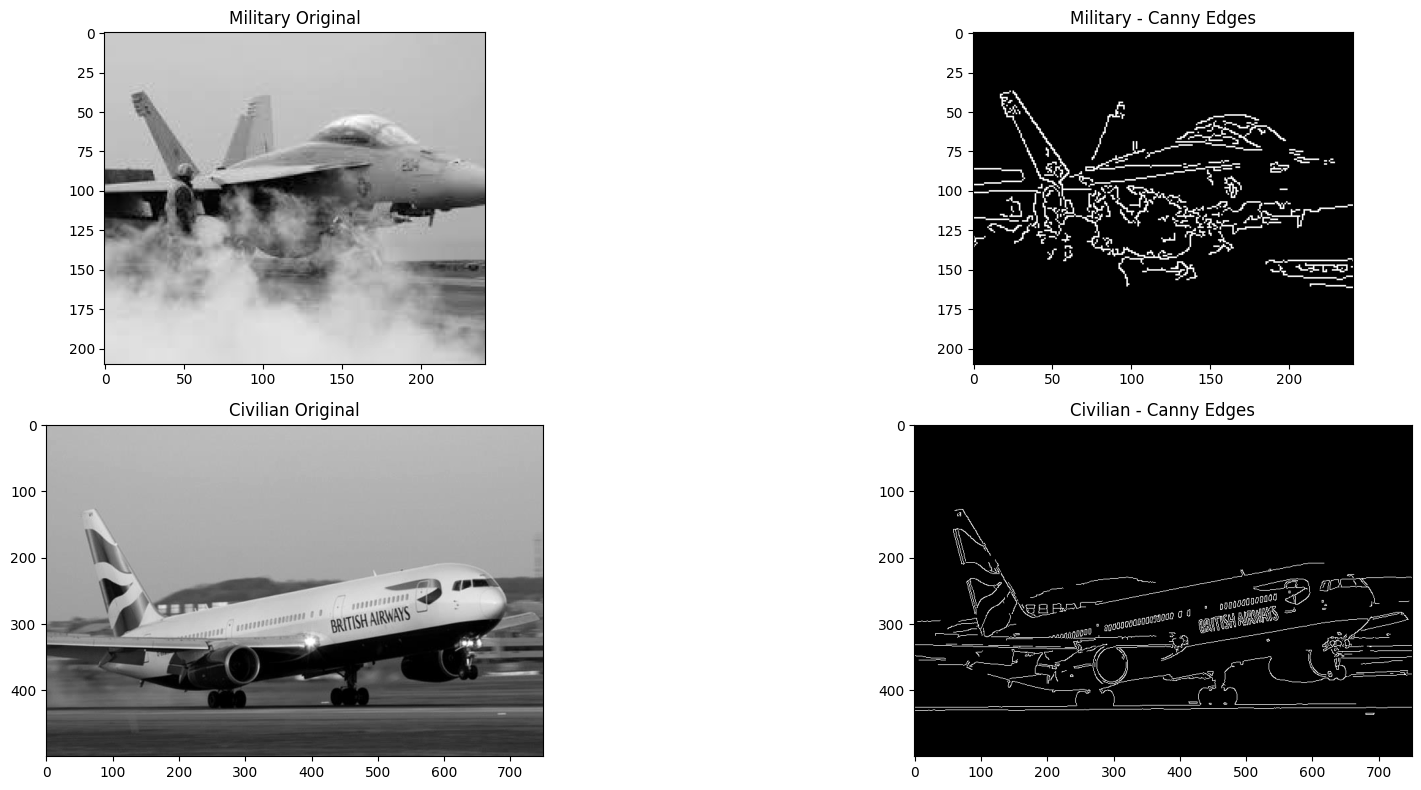

In [8]:
import cv2
import matplotlib.pyplot as plt

# Load images
military_img = cv2.imread(military_image, cv2.IMREAD_GRAYSCALE)
civilian_img = cv2.imread(civilian_image, cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection
military_edges = cv2.Canny(military_img, 100, 200)
civilian_edges = cv2.Canny(civilian_img, 100, 200)

# Display images
plt.figure(figsize=(20,8))
plt.subplot(2,2,1), plt.imshow(military_img, cmap='gray'), plt.title("Military Original")
plt.subplot(2,2,2), plt.imshow(military_edges, cmap='gray'), plt.title("Military - Canny Edges")
plt.subplot(2,2,3), plt.imshow(civilian_img, cmap='gray'), plt.title("Civilian Original")
plt.subplot(2,2,4), plt.imshow(civilian_edges, cmap='gray'), plt.title("Civilian - Canny Edges")
plt.tight_layout()
plt.show()

### Step 3: Apply HOG (Histogram of Oriented Gradients)
This computes and visualizes __HOG features__ for the selected military and civilian vehicle images.

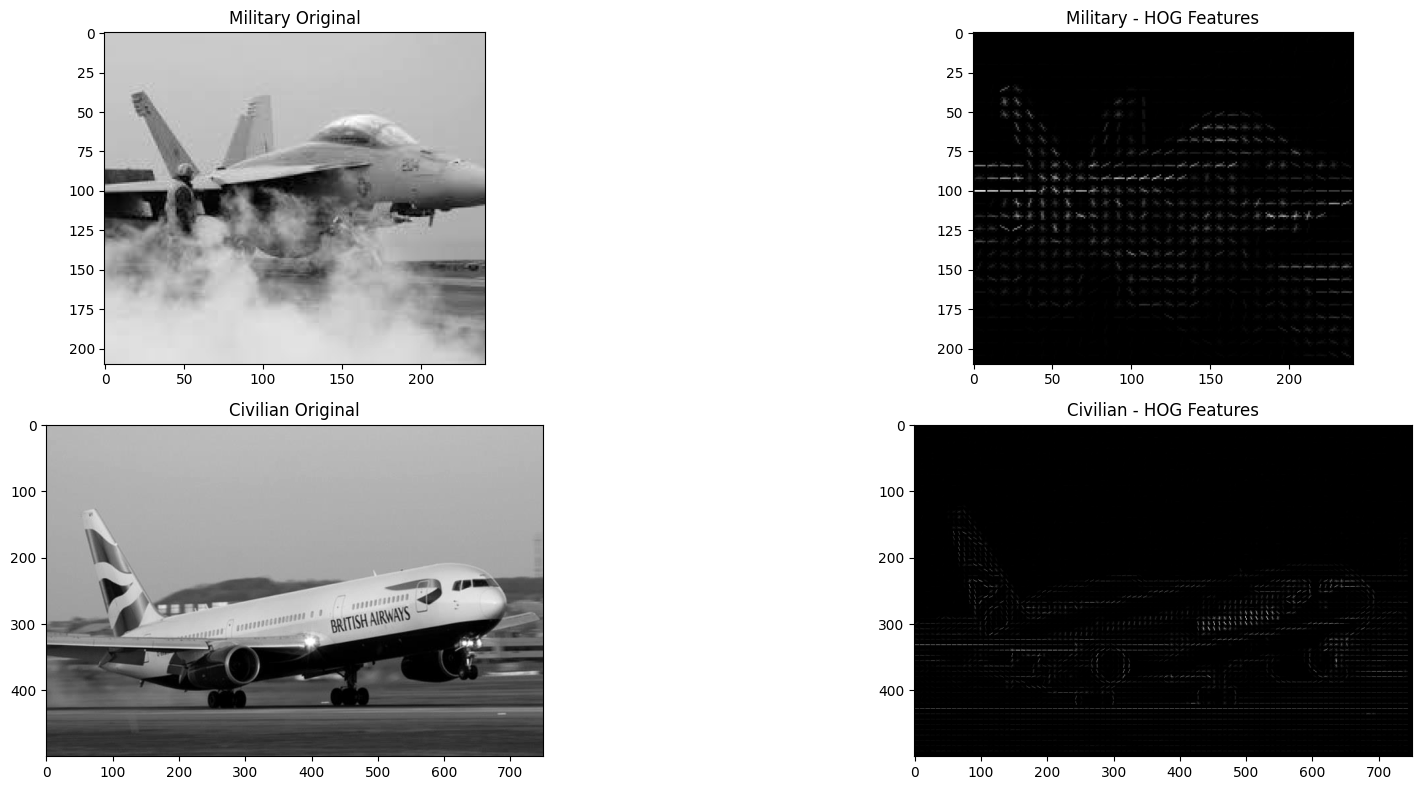

In [9]:
from skimage.feature import hog

# Compute HOG features
military_features, military_hog_img = hog(military_img, visualize=True)
civilian_features, civilian_hog_img = hog(civilian_img, visualize=True)

# Display images
plt.figure(figsize=(20,8))
plt.subplot(2,2,1), plt.imshow(military_img, cmap='gray'), plt.title("Military Original")
plt.subplot(2,2,2), plt.imshow(military_hog_img, cmap='gray'), plt.title("Military - HOG Features")
plt.subplot(2,2,3), plt.imshow(civilian_img, cmap='gray'), plt.title("Civilian Original")
plt.subplot(2,2,4), plt.imshow(civilian_hog_img, cmap='gray'), plt.title("Civilian - HOG Features")
plt.tight_layout()
plt.show()

### Step 4: Apply Color Histogram
This extracts and visualizes __color histograms__ for __military and civilian images__.

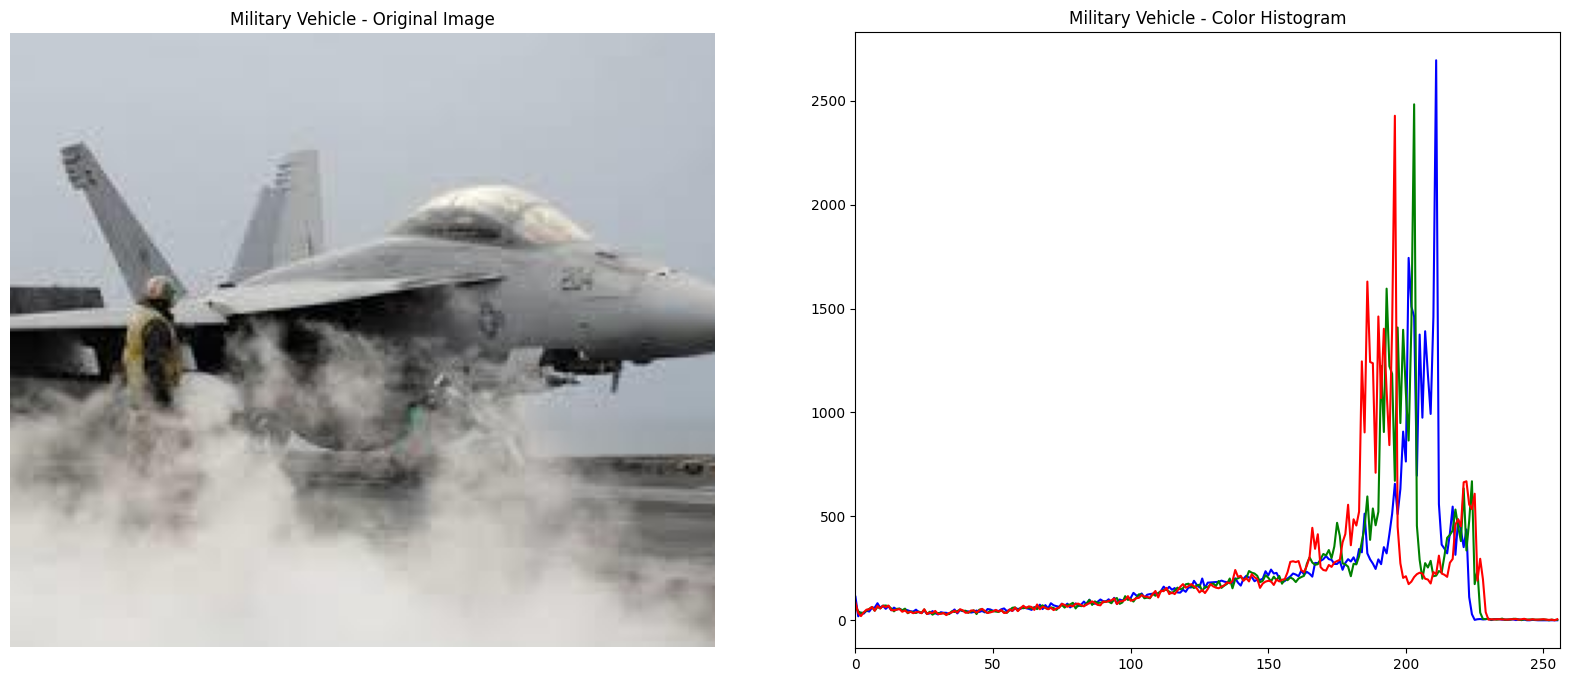

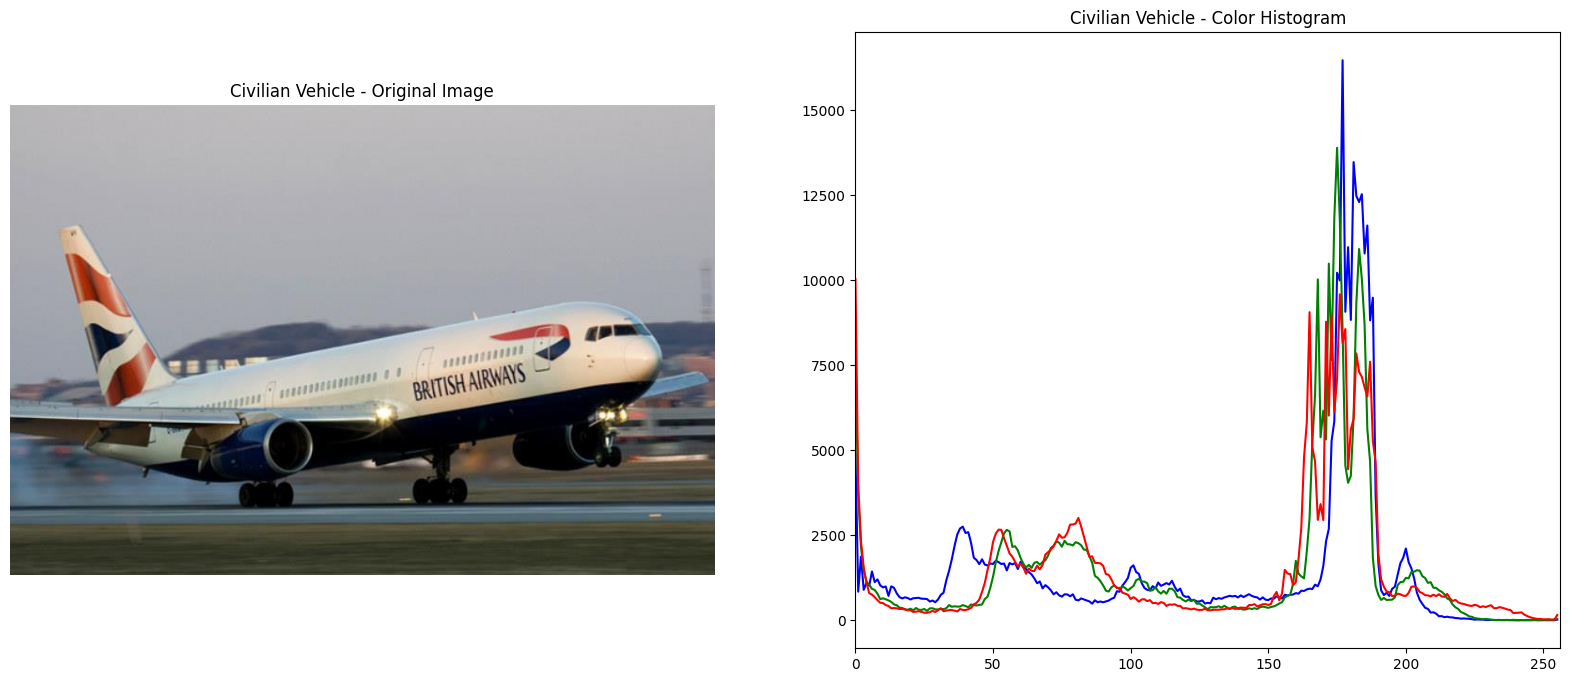

In [10]:
# Load images in color
military_img_color = cv2.imread(military_image)
civilian_img_color = cv2.imread(civilian_image)

# Function to plot color histogram alongside original image
def plot_image_and_histogram(image, title):
    color = ('b','g','r')
    
    plt.figure(figsize=(20,8))
    
    # Show original image
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"{title} - Original Image")
    
    # Show color histogram
    plt.subplot(1,2,2)
    for i, col in enumerate(color):
        hist = cv2.calcHist([image],[i],None,[256],[0,256])
        plt.plot(hist, color=col)
        plt.xlim([0,256])
    plt.title(f"{title} - Color Histogram")
    
    plt.show()

# Display images and histograms
plot_image_and_histogram(military_img_color, "Military Vehicle")
plot_image_and_histogram(civilian_img_color, "Civilian Vehicle")


### Summary of Features (week 03)
* Edge Detection (Canny) – Highlights vehicle shape and structure
* Histogram of Oriented Gradients (HOG) – Captures vehicle shape for classification
* Color Histogram – Analyzes differences in military (camouflage) vs. civilian colors

### Weekly Updates (week 04):
* HSV: Military vehicles should have lower saturation, while civilian vehicles should show higher saturation variations.
* LAB: Military vehicles may have lower A/B channel variation, while civilian vehicles show more color diversity.

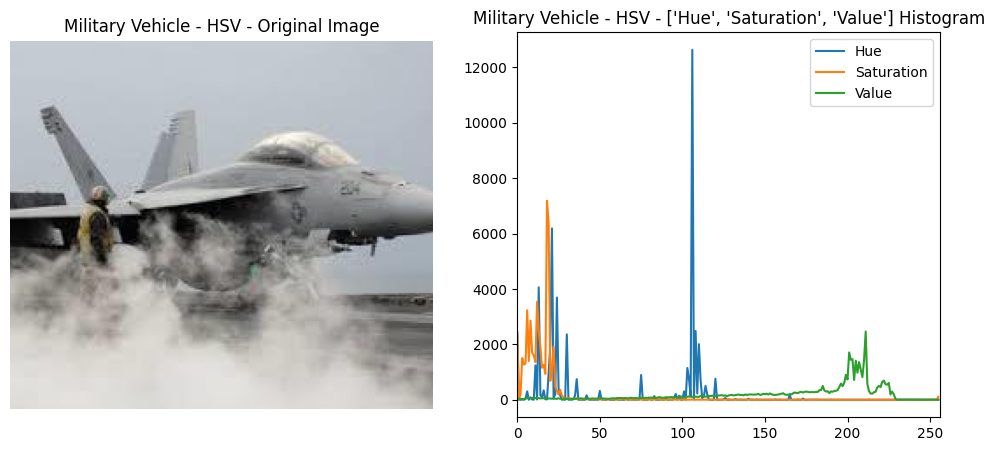

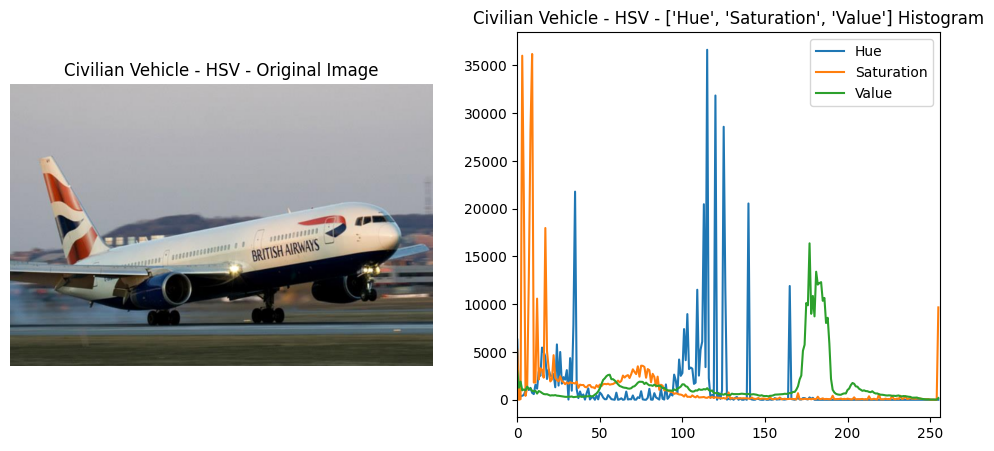

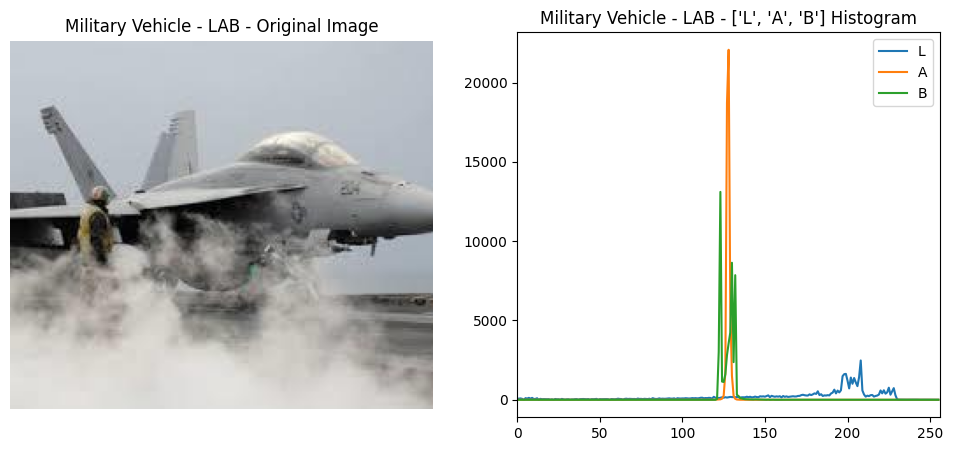

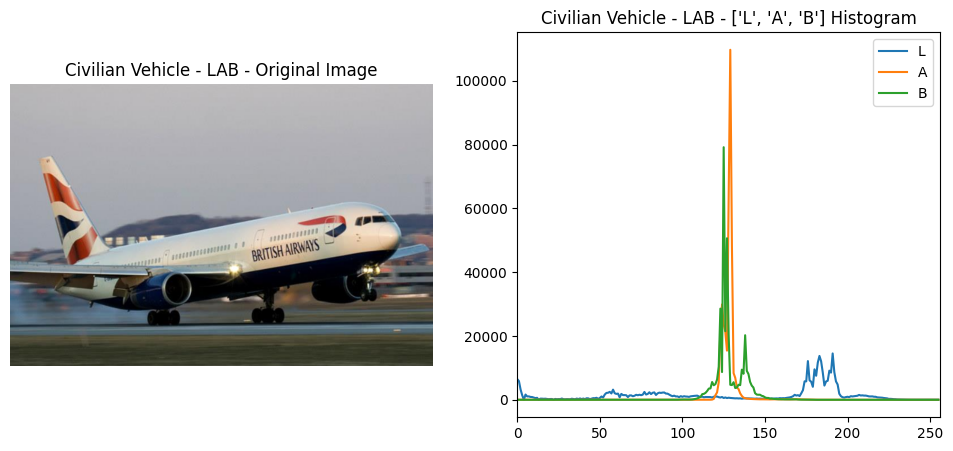

In [11]:

# Load images in color
military_img_color = cv2.imread(military_image)
civilian_img_color = cv2.imread(civilian_image)

# Convert to different color spaces
military_hsv = cv2.cvtColor(military_img_color, cv2.COLOR_BGR2HSV)
civilian_hsv = cv2.cvtColor(civilian_img_color, cv2.COLOR_BGR2HSV)

military_lab = cv2.cvtColor(military_img_color, cv2.COLOR_BGR2LAB)
civilian_lab = cv2.cvtColor(civilian_img_color, cv2.COLOR_BGR2LAB)

# Function to plot original image and corresponding histogram
def plot_image_and_histogram(image, color_space_image, title, color_space_labels):
    plt.figure(figsize=(12,5))

    # Show original image
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"{title} - Original Image")

    # Show color histogram
    plt.subplot(1,2,2)
    for i, col in enumerate(color_space_labels):
        hist = cv2.calcHist([color_space_image], [i], None, [256], [0,256])
        plt.plot(hist, label=col)
        plt.xlim([0,256])
    plt.title(f"{title} - {color_space_labels} Histogram")
    plt.legend()
    plt.show()

# Plot HSV histograms
plot_image_and_histogram(military_img_color, military_hsv, "Military Vehicle - HSV", ['Hue', 'Saturation', 'Value'])
plot_image_and_histogram(civilian_img_color, civilian_hsv, "Civilian Vehicle - HSV", ['Hue', 'Saturation', 'Value'])

# Plot LAB histograms
plot_image_and_histogram(military_img_color, military_lab, "Military Vehicle - LAB", ['L', 'A', 'B'])
plot_image_and_histogram(civilian_img_color, civilian_lab, "Civilian Vehicle - LAB", ['L', 'A', 'B'])


In [20]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog


# Define class names
classes = ["military tank", "military helicopter", "civilian car", 
           "military aircraft", "military truck", "civilian aircraft"]

# Sample one image per class
sampled_images = {}
for class_name in classes:
    sampled_images[class_name] = prefix_image+df_cleaned[df_cleaned["class"] == class_name].sample(1)["filename"].values[0]

sampled_images

{'military tank': 'Military_and_Civilian_Vehicles_Classification/Images/t90-main-battle-tank-russia_9.jpg',
 'military helicopter': 'Military_and_Civilian_Vehicles_Classification/Images/images46(6).jpg',
 'civilian car': 'Military_and_Civilian_Vehicles_Classification/Images/Auto_-770x433.jpg',
 'military aircraft': 'Military_and_Civilian_Vehicles_Classification/Images/defender-stargate-star-fox-command-video-game-wiki-galacticos-future-technology-top-view-star-wars.jpg',
 'military truck': 'Military_and_Civilian_Vehicles_Classification/Images/Armored-Personnel-Carrier-India-Panthera-F9-APC-.jpg',
 'civilian aircraft': 'Military_and_Civilian_Vehicles_Classification/Images/images190(10).jpg'}

In [21]:
# Function to apply edge detection
def apply_canny(image):
    return cv2.Canny(image, 100, 200)

# Function to apply HOG feature extraction
def apply_hog(image):
    features, hog_image = hog(image, visualize=True)
    return hog_image

# Function to compute color histograms
def compute_color_histogram(image, color_space):
    hist_data = []
    color_labels = []
    
    if color_space == "RGB":
        converted = image
        color_labels = ['Red', 'Green', 'Blue']
    elif color_space == "HSV":
        converted = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        color_labels = ['Hue', 'Saturation', 'Value']
    elif color_space == "LAB":
        converted = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        color_labels = ['L', 'A', 'B']
    
    for i, col in enumerate(color_labels):
        hist = cv2.calcHist([converted], [i], None, [256], [0,256])
        hist_data.append(hist)
    
    return hist_data, color_labels

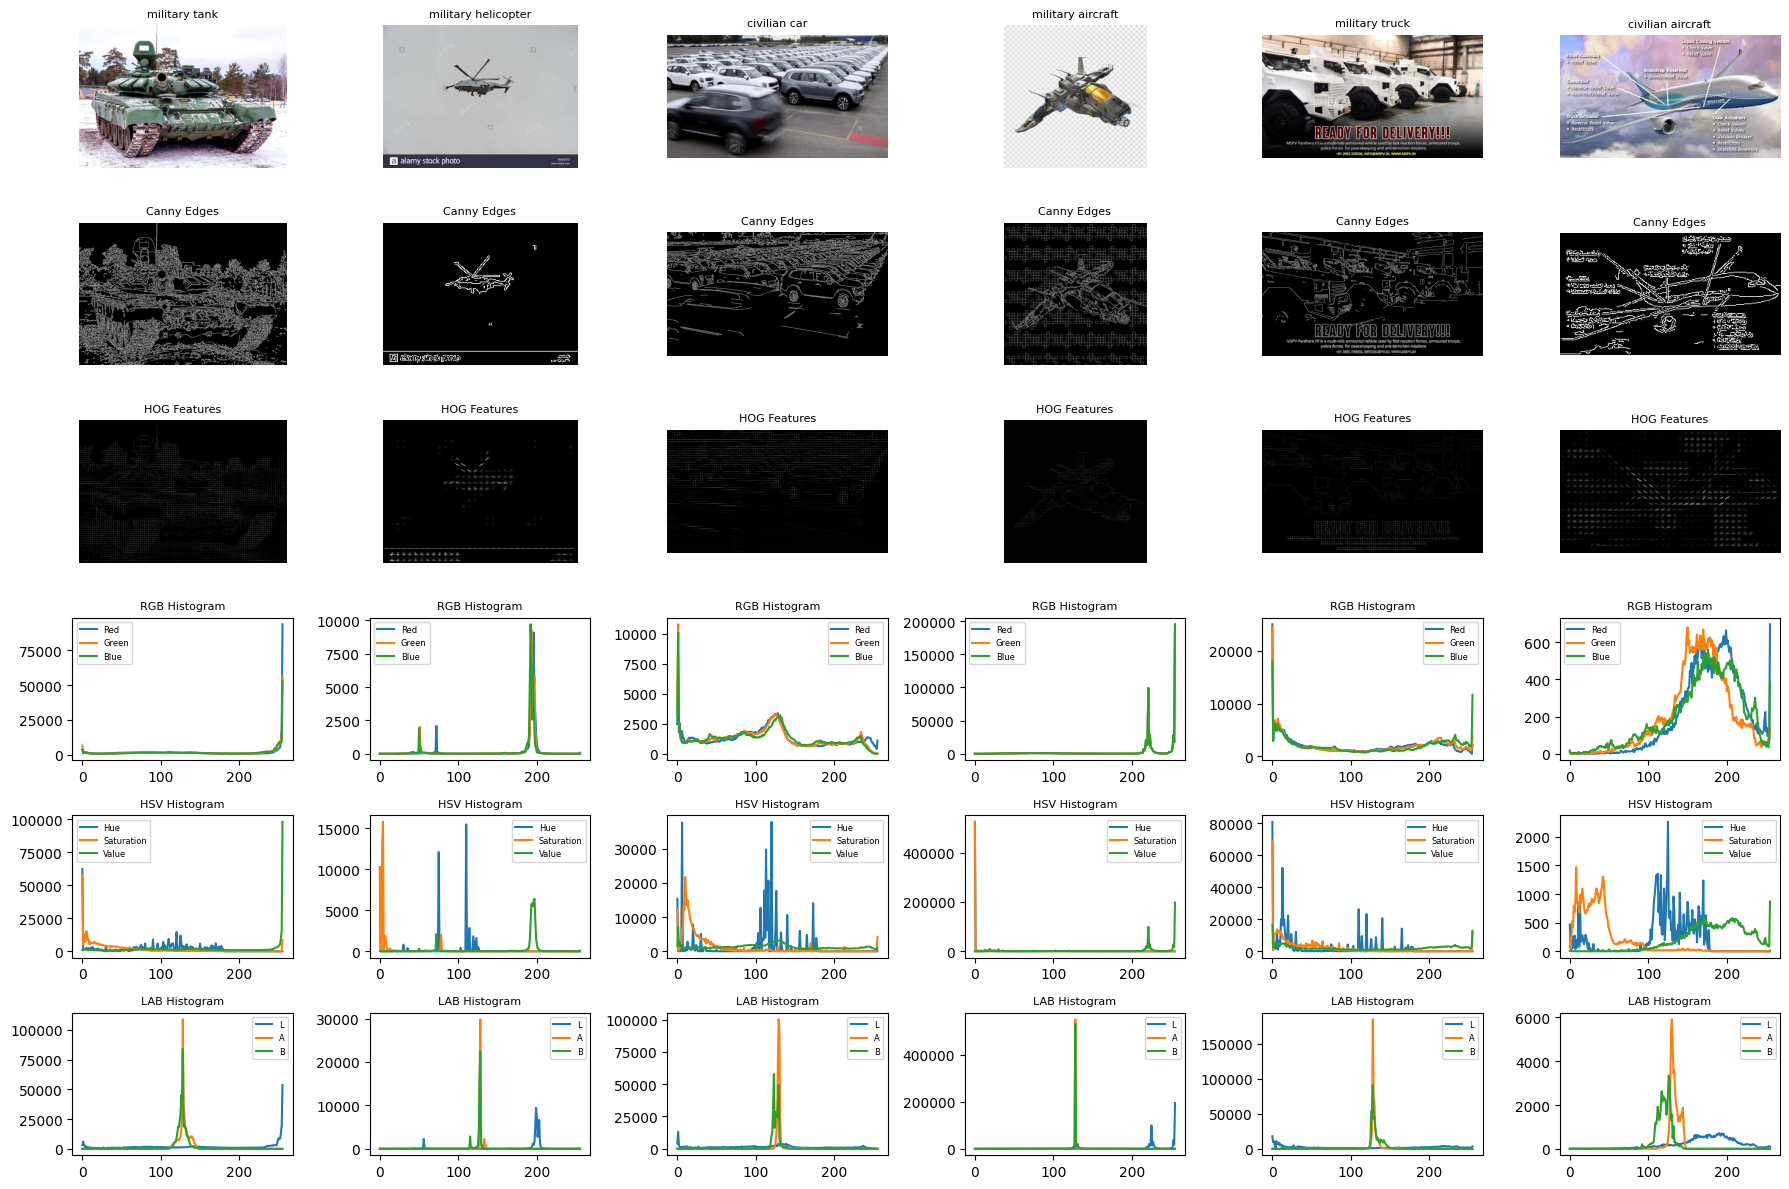

In [22]:
# Plot all features in a single figure
fig, axes = plt.subplots(6, len(classes), figsize=(18, 12))

# Process each image per class
for idx, (class_name, image_path) in enumerate(sampled_images.items()):
    # Load original image
    img_color = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    
    # Edge Detection
    img_canny = apply_canny(img_gray)
    
    # HOG Feature Extraction
    img_hog = apply_hog(img_gray)
    
    # Color Histograms
    rgb_hist, rgb_labels = compute_color_histogram(img_color, "RGB")
    hsv_hist, hsv_labels = compute_color_histogram(img_color, "HSV")
    lab_hist, lab_labels = compute_color_histogram(img_color, "LAB")
    
    # Row 1: Original Images
    axes[0, idx].imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    axes[0, idx].set_title(class_name, fontsize=8)
    axes[0, idx].axis("off")
    
    # Row 2: Canny Edge Detection
    axes[1, idx].imshow(img_canny, cmap='gray')
    axes[1, idx].axis("off")
    axes[1, idx].set_title("Canny Edges", fontsize=8)
    
    # Row 3: HOG Features
    axes[2, idx].imshow(img_hog, cmap='gray')
    axes[2, idx].axis("off")
    axes[2, idx].set_title("HOG Features", fontsize=8)
    
    # Row 4: RGB Color Histogram
    for i in range(3):
        axes[3, idx].plot(rgb_hist[i], label=rgb_labels[i])
    axes[3, idx].set_title("RGB Histogram", fontsize=8)
    axes[3, idx].legend(fontsize=6)
    
    # Row 5: HSV Color Histogram
    for i in range(3):
        axes[4, idx].plot(hsv_hist[i], label=hsv_labels[i])
    axes[4, idx].set_title("HSV Histogram", fontsize=8)
    axes[4, idx].legend(fontsize=6)
    
    # Row 6: LAB Color Histogram
    for i in range(3):
        axes[5, idx].plot(lab_hist[i], label=lab_labels[i])
    axes[5, idx].set_title("LAB Histogram", fontsize=8)
    axes[5, idx].legend(fontsize=6)

# Adjust layout
plt.tight_layout()
plt.show()

Week 5 Updates
Preprocess the Dataset (Beyond Edge Detection)
- Resize images: Uniform dimensions (e.g., 800x600) for model input.
- Augment data: Use transformations (flips, rotations, etc.) to improve generalization

Next Steps: 
- Normalize pixel values: Scale to [0, 1] or standardize using mean/std.
- Split data: Divide into train/validation/test sets (e.g., 70%/15%/15%).
- Pick the pre-trained model and start training

In [7]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from glob import glob
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import seaborn as sns
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')

# Load all data and pair with training labels
import pandas as pd

# Load dataset
prefix_label = "Military_and_Civilian_Vehicles_Classification/Labels/CSV_Format/"
df = pd.read_csv(prefix_label+"train_labels.csv")

# Display multi-label dataset
df
# Add column in metadata dataset to full path to each image
base_car_dir = 'Military_and_Civilian_Vehicles_Classification/Images'
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_car_dir, '**/*.jpg'), recursive=True)  # Searches subfolders
}
df['path'] = df['filename'].apply(lambda x: imageid_path_dict.get(os.path.splitext(x)[0]))
print(df.head())

                                 filename  width  height              class  \
0   000_14M0LD-e1525732547750-400x250.jpg    400     250      military tank   
1   000_14M0LD-e1525732547750-400x250.jpg    400     250      military tank   
2                000_1H95VB.width-800.jpg    800     532  military aircraft   
3  000_1LC27X-e1570900274807-1024x640.jpg   1024     640      military tank   
4  000_1LC27X-e1570900274807-1024x640.jpg   1024     640     military truck   

   xmin  ymin  xmax  ymax                                               path  
0   121    60   220   144  Military_and_Civilian_Vehicles_Classification/...  
1   198   108   371   197  Military_and_Civilian_Vehicles_Classification/...  
2    30   168   622   505  Military_and_Civilian_Vehicles_Classification/...  
3    78    92   858   563  Military_and_Civilian_Vehicles_Classification/...  
4   816   288  1012   554  Military_and_Civilian_Vehicles_Classification/...  


In [9]:
# Reduce variance in image sizes

import cv2
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Analyze current size distribution
print(f"Original width range: {df['width'].min()} - {df['width'].max()}")
print(f"Original height range: {df['height'].min()} - {df['height'].max()}")

# Calculate aspect ratios
df['aspect_ratio'] = df['width'] / df['height']
print(f"Aspect ratio range: {df['aspect_ratio'].min():.2f} - {df['aspect_ratio'].max():.2f}")

# Determine target size based on percentiles
target_width = 800  # covers ~85% of images based on your ranges
target_height = 600

Original width range: 84 - 7800
Original height range: 100 - 7472
Aspect ratio range: 0.36 - 5.05


In [10]:
# Augment the data

def get_train_transform(target_width, target_height):
    return A.Compose([
        # Basic resizing - maintain aspect ratio with padding
        A.LongestMaxSize(max_size=max(target_width, target_height), p=1.0),
        A.PadIfNeeded(
            min_height=target_height,
            min_width=target_width,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,  # Black padding
            p=1.0
        ),

        # Geometric transformations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),  # Less common for these objects
        A.Rotate(limit=15, p=0.5),  # Moderate rotation
        A.RandomScale(scale_limit=0.2, p=0.5),  # Zoom in/out

        # Color transformations
        A.RandomBrightnessContrast(p=0.3),
        A.HueSaturationValue(p=0.3),
        A.CLAHE(p=0.2),

        # Noise and blur
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),

        # Occasionally crop parts of the image
        A.RandomSizedBBoxSafeCrop(
            height=target_height,
            width=target_width,
            erosion_rate=0.2,  # Ensure boxes aren't cropped too much
            p=0.3
        ),

        # Normalize and convert to tensor
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(
        format='pascal_voc',  # xmin, ymin, xmax, ymax
        label_fields=['class_labels']
    ))

def get_valid_transform(target_width, target_height):
    return A.Compose([
        A.LongestMaxSize(max_size=max(target_width, target_height), p=1.0),
        A.PadIfNeeded(
            min_height=target_height,
            min_width=target_width,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=1.0
        ),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['class_labels']
    ))

In [11]:
#custom dataset class
import torch
from torch.utils.data import Dataset

class ObjectDetectionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.classes = sorted(dataframe['class'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        record = self.dataframe.iloc[idx]

        # Load image
        image_path = os.path.join(self.image_dir, record['filename'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get bounding box and class
        bbox = [record['xmin'], record['ymin'], record['xmax'], record['ymax']]
        class_label = self.class_to_idx[record['class']]

        # Apply transformations
        if self.transforms:
            transformed = self.transforms(
                image=image,
                bboxes=[bbox],
                class_labels=[class_label]
            )

            image = transformed['image']
            bbox = transformed['bboxes'][0]
            class_label = transformed['class_labels'][0]

        # Convert everything to tensor
        bbox = torch.tensor(bbox, dtype=torch.float32)
        class_label = torch.tensor(class_label, dtype=torch.int64)

        return image, bbox, class_label

In [12]:
# Visualize the transformation

def visualize_augmentations(dataset, idx=0, samples=5):
    dataset.transforms = get_train_transform(target_width, target_height)
    fig, axes = plt.subplots(1, samples, figsize=(20, 5))

    for i in range(samples):
        image, bbox, class_label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        image = image.clip(0, 255).astype(np.uint8)

        # Draw bounding box
        xmin, ymin, xmax, ymax = map(int, bbox)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[class_label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

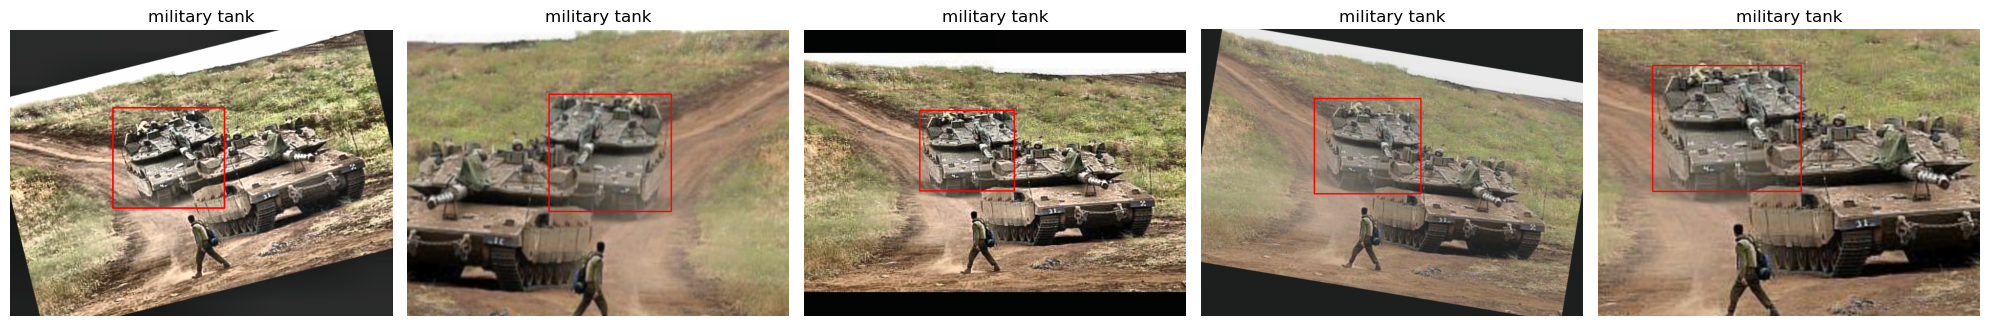

In [13]:
train_dataset = ObjectDetectionDataset(
    dataframe=df,
    image_dir=base_car_dir,
    transforms=get_train_transform(target_width, target_height)
)

# Visualize augmentations
visualize_augmentations(train_dataset, idx=0)

### PCA Explained Variance for HOG and RGB Features
* Goal: Evaluate how much information (variance) is captured by top principal components
* Data: 5 samples per class × 6 classes = 30 total images

In [41]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ------------------ Load Data ------------------
# Load cleaned label data
df_cleaned = pd.read_csv("./train_labels_cleaned.csv")

# Define classes of interest
classes = ["military tank", "military helicopter", "civilian car", 
           "military aircraft", "military truck", "civilian aircraft"]

# Path to image folder
prefix_image = "Military_and_Civilian_Vehicles_Classification/Images/"

# Sample 5 image per class
sampled_images = {}
for class_name in classes:
    sampled_images[class_name] = list(prefix_image + df_cleaned[df_cleaned["class"] == class_name].sample(5)["filename"].values[:])

In [42]:
# ------------------ Feature Extraction ------------------

# Function to compute color histograms
def compute_color_histogram(image, color_space):
    hist_data = []
    if color_space == "RGB":
        converted = image
    elif color_space == "HSV":
        converted = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == "LAB":
        converted = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    else:
        raise ValueError("Unsupported color space")

    for i in range(3):
        hist = cv2.calcHist([converted], [i], None, [256], [0,256])
        hist_data.append(hist)
    
    return hist_data

In [43]:
# ------------------ PCA Explained Variance Plot ------------------

def plot_pca_explained_variance(X_features, feature_name="Feature"):
    # Standardize
    X_scaled = StandardScaler().fit_transform(X_features)

    # PCA
    pca = PCA()
    pca.fit(X_scaled)

    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(1, len(explained_variance)+1), cumulative_variance, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'PCA Explained Variance - {feature_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [44]:
# ------------------ Extract Features ------------------

hog_features = []
rgb_hist_features = []
labels = []

# ------------------ Loop through all sampled images ------------------
for class_name, image_paths in sampled_images.items():
    for image_path in image_paths:
        # Load and resize image
        img_color = cv2.imread(image_path)
        if img_color is None:
            print(f"Warning: could not read {image_path}")
            continue  # skip unreadable files
        img_resized = cv2.resize(img_color, (128, 128))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        # HOG feature
        hog_vec, _ = hog(img_gray, visualize=True)
        hog_features.append(hog_vec)

        # RGB histogram feature
        rgb_hist = compute_color_histogram(img_resized, "RGB")
        rgb_vec = np.concatenate([h.ravel() for h in rgb_hist])
        rgb_hist_features.append(rgb_vec)

        # Store label
        labels.append(class_name)
        
# Convert to numpy arrays
hog_features = np.array(hog_features)
rgb_hist_features = np.array(rgb_hist_features)
labels = np.array(labels)

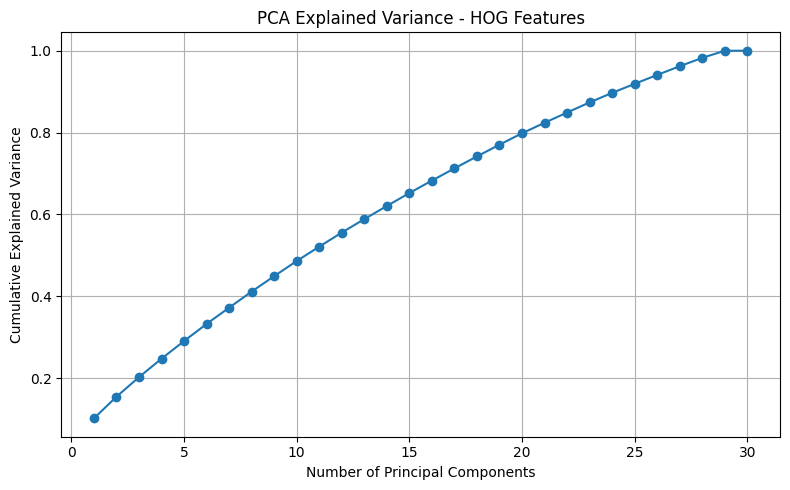

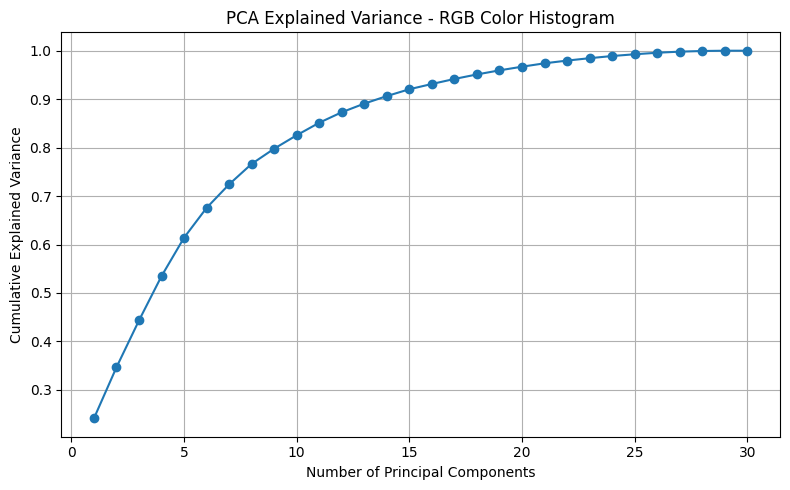

In [45]:
# ------------------ PCA Plots ------------------

plot_pca_explained_variance(hog_features, "HOG Features")
plot_pca_explained_variance(rgb_hist_features, "RGB Color Histogram")

### PCA Explained Variance for HOG and RGB Features
* Goal: Evaluate how much information (variance) is captured by top principal components
* Data: 5 samples per class × 6 classes = 30 total images
* HOG features are richer but require more components to preserve structure. (need more components to capture the full variance)
* RGB histograms are more compact and compressible. Fewer components are needed to retain most color information. (15 principal components explain over 90% variance.)